# Analyse des POST sur Facebook

## Imports

In [775]:
import pandas as pd
import matplotlib.pyplot as plt

## Lecture du DataSet

In [776]:
dataframe = pd.read_csv("articles_data.csv")
dataframe.head(1)

,index,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0


## Manipulation du DataSet pour travailler sur le `published_at`

In [777]:
dataframe_converted_datetime = dataframe

# Conversion de `published_at` en DateTime
dataframe_converted_datetime.published_at = pd.to_datetime(dataframe.published_at)
#dataframe_converted_datetime.published_at.dtypes # Afficher le type de `published_at`

# Ligne 750 corrompue
dataframe_converted_datetime = dataframe_converted_datetime.drop(index=750)
# Réindexation
dataframe_converted_datetime.index = [i for i in range(0, len(dataframe_converted_datetime))] 

# Pour retrouver les lignes dont le `published_at` == NaN
#dataframe_converted_datetime[dataframe_converted_datetime.published_at.isnull()]

# Ajout d'une nouvelle colonne pour avoir les différentes tranches horaires
serie_temp = pd.Series(
    [ int(df_datetime.hour) for df_datetime in dataframe_converted_datetime.published_at ],  
    name='tranche_horaire'
)

dataframe_converted_datetime = pd.concat(
    [dataframe_converted_datetime, serie_temp],
    axis=1,
    ignore_index=False
)

## Quels sont les moments (date) de publication qui récoltent le plus de likes, partages et commentaires

## Nombre de POST par tranche horaire

In [778]:
# Nombre d'article posté par tranche horaire
nb_post_by_hours = dataframe_converted_datetime.groupby(['tranche_horaire']) \
                            .size() \
                            .reset_index(name='counts') \
                            .sort_values('counts', ascending=False)

nb_post_by_hours

,tranche_horaire,counts
16,16,1460
15,15,1432
14,14,1237
17,17,1003
13,13,918
12,12,837
11,11,716
10,10,533
9,9,526
18,18,324


## Nombre de REACTION par tranche horaire

In [779]:
# Nombre de 'REACTION' par tranche horaire
nb_reaction_by_hours = dataframe_converted_datetime.groupby(['tranche_horaire']) \
                            .engagement_reaction_count \
                            .sum() \
                            .reset_index(name='sum_like') \
                            .sort_values('sum_like', ascending=False)
nb_reaction_by_hours

,tranche_horaire,sum_like
10,10,517434.0
15,15,443402.0
14,14,406498.0
13,13,362689.0
12,12,284878.0
16,16,265871.0
11,11,248854.0
17,17,234314.0
9,9,199809.0
5,5,189613.0


## Nombre de PARTAGE par tranche horaire

In [780]:
# Nombre de 'PARTAGE' par tranche horaire
nb_share_by_hours = dataframe_converted_datetime.groupby(['tranche_horaire']) \
                            .engagement_share_count \
                            .sum() \
                            .reset_index(name='sum_share') \
                            .sort_values('sum_share', ascending=False)
nb_share_by_hours

,tranche_horaire,sum_share
17,17,312623.0
15,15,267938.0
14,14,241617.0
16,16,202078.0
13,13,190777.0
10,10,114434.0
12,12,113571.0
11,11,109263.0
18,18,104206.0
9,9,73980.0


## Nombre de COMMENTAIRE par tranche horaire

In [781]:
# Nombre de 'COMMENTAIRE' par tranche horaire
nb_comment_by_hours = dataframe_converted_datetime.groupby(['tranche_horaire']) \
                            .engagement_comment_count \
                            .sum() \
                            .reset_index(name='sum_comment') \
                            .sort_values('sum_comment', ascending=False)
nb_comment_by_hours

,tranche_horaire,sum_comment
14,14,159499.0
15,15,152732.0
13,13,120280.0
10,10,118095.0
16,16,111010.0
11,11,103449.0
12,12,94131.0
5,5,67975.0
17,17,66503.0
9,9,60188.0


## Stats MATIN / MIDI / APRES-MIDI / SOIR / NUIT

_Horaire_ :
* **Matin** :       *8h à 11h*
* **Midi** :        *11h à 14h*
* **Après-midi** :  *14h à 19h*
* **Soir** :        *19h à 00h*
* **Nuit** :        *00h à 8h*

## Fonction pour filtrer les différentes périodes de la journée

In [782]:
def periodOfTheDay(hour) :
    if (hour >= 0 and hour < 8) :
        return 'night'
    elif (hour < 11) :
        return 'morning'
    elif (hour < 14) :
        return 'midday'
    elif (hour < 19) :
        return 'afternoon'
    else :
        return 'evening'


## Regroupement REACTION par période

In [783]:
nb_reaction_by_period = nb_reaction_by_hours
nb_reaction_by_period.columns = ['period', 'reactions']
nb_reaction_by_period.period = nb_reaction_by_period \
                                .period \
                                .apply(periodOfTheDay) \

nb_reaction_by_period = nb_reaction_by_period.groupby(['period']) \
                        .sum() \
                        .sort_values('reactions', ascending=False)

nb_reaction_by_period

,reactions
period,
afternoon,1379412.0
midday,896421.0
night,872343.0
morning,786114.0
evening,1328.0


## Regroupement PARTAGE par période

In [784]:
nb_share_by_period = nb_share_by_hours
nb_share_by_period.columns = ['period', 'shares']
nb_share_by_period.period = nb_share_by_period \
                                .period \
                                .apply(periodOfTheDay) \

nb_share_by_period = nb_share_by_period.groupby(['period']) \
                        .sum() \
                        .sort_values('shares', ascending=False)

nb_share_by_period

,shares
period,
afternoon,1128462.0
midday,413611.0
night,247861.0
morning,210661.0
evening,24367.0


## Regroupement COMMENTAIRE par période

In [785]:
nb_comment_by_period = nb_comment_by_hours
nb_comment_by_period.columns = ['period', 'comments']
nb_comment_by_period.period = nb_comment_by_period \
                                .period \
                                .apply(periodOfTheDay) \

nb_comment_by_period = nb_comment_by_period.groupby(['period']) \
                        .sum() \
                        .sort_values('comments', ascending=False)

nb_comment_by_period

,comments
period,
afternoon,501403.0
midday,317860.0
night,256784.0
morning,203440.0
evening,409.0


## Est-ce que la mise en avant d'un article sur le site produit plus d'engagement ?

## Récupération des articles mis en avant

**Statistiques générales sur les top articles** :

In [786]:
# Récupération des top articles
top_article = dataframe[dataframe.top_article == 1]
# Calcule du pourcentage de top articles par rapport au total d'article
pourcent_top_article = len(top_article) / len(dataframe) * 100

# Sum total des articles sur reaction / share / comment
sum_article_reaction = dataframe.engagement_reaction_count.sum()
sum_article_share = dataframe.engagement_share_count.sum()
sum_article_comment = dataframe.engagement_comment_count.sum()

print("Pourcentage des articles en top : " + str(round(pourcent_top_article, 2)) + "%")

print("\n")

print("Somme des reactions articles : " + str(sum_article_reaction))
print("Somme des partages articles : " + str(sum_article_share))
print("Somme des commentaires articles : " + str(sum_article_comment))

Pourcentage des articles en top : 12.21%


Somme des reactions articles : 3935618.0
Somme des partages articles : 2024962.0
Somme des commentaires articles : 1279896.0


**Statistiques sur les différentes actions possibles**

In [787]:
# Sum des top articles sur reaction / share / comment
sum_top_article_reaction = top_article.engagement_reaction_count.sum()
sum_top_article_share = top_article.engagement_share_count.sum()
sum_top_article_comment = top_article.engagement_comment_count.sum()

print("Somme des reactions des top articles : " + str(sum_top_article_reaction))
print("Somme des partages des top articles : " + str(sum_top_article_share))
print("Somme des commentaires des top articles : " + str(sum_top_article_comment))

print("\n")

# Pourcentage des sum
pourcent_top_reaction = sum_top_article_reaction / sum_article_reaction * 100
pourcent_top_share = sum_top_article_share / sum_article_share * 100
pourcent_top_comment = sum_top_article_comment / sum_article_comment * 100

print("Pourcentage des reactions des top articles : " + str(round(pourcent_top_reaction, 2)) + "%")
print("Pourcentage des partages des top articles : " + str(round(pourcent_top_share, 2)) + "%")
print("Pourcentage des commentaires des top articles : " + str(round(pourcent_top_comment, 2)) + "%")


Somme des reactions des top articles : 944225.0
Somme des partages des top articles : 720563.0
Somme des commentaires des top articles : 360352.0


Pourcentage des reactions des top articles : 23.99%
Pourcentage des partages des top articles : 35.58%
Pourcentage des commentaires des top articles : 28.15%


## **Récapitulatif :**

In [788]:
print("Pourcentage des articles en top : " + str(round(pourcent_top_article, 2)) + "%")

print("\n")

print("Pourcentage des reactions des top articles : " + str(round(pourcent_top_reaction, 2)) + "%")
print("Pourcentage des partages des top articles : " + str(round(pourcent_top_share, 2)) + "%")
print("Pourcentage des commentaires des top articles : " + str(round(pourcent_top_comment, 2)) + "%")

Pourcentage des articles en top : 12.21%


Pourcentage des reactions des top articles : 23.99%
Pourcentage des partages des top articles : 35.58%
Pourcentage des commentaires des top articles : 28.15%


## Représentation graphique

**Fonction pour la création d'un graphique `Pie` avec mathplotlib**

In [789]:
# Create pie chart with matplotlib
def createPieChart(title, datas, labels, explode, autopct = '%1.2f%%') :
    fig, ax = plt.subplots()
    
    ax.pie(datas, explode=explode, labels=labels, autopct=autopct,
            shadow=True, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(title)

    plt.show()

**Graphique pour `REACTION`**

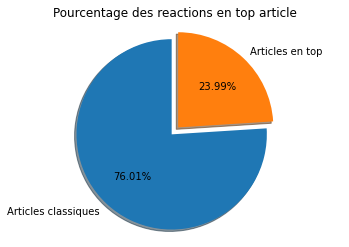

In [790]:
# REACTIONS
title_reaction = "Pourcentage des reactions en top article"
datas_reaction = [100-pourcent_top_reaction, pourcent_top_reaction]
labels_reaction = ['Articles classiques', 'Articles en top']
explode = (0, 0.1)

createPieChart(title_reaction, datas_reaction, labels_reaction, explode)


**Graphique pour `PARTAGE`**

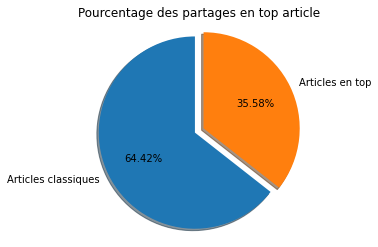

In [791]:
# SHARE
title_share = "Pourcentage des partages en top article"
datas_share = [100-pourcent_top_share, pourcent_top_share]
labels_share = ['Articles classiques', 'Articles en top']
explode = (0, 0.1)

createPieChart(title_share, datas_share, labels_share, explode)

**Graphique pour `COMMENTAIRE`**

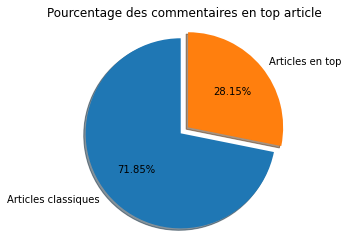

In [792]:
# COMMENT
title_comment = "Pourcentage des commentaires en top article"
datas_comment = [100-pourcent_top_comment, pourcent_top_comment]
labels_comment = ['Articles classiques', 'Articles en top']
explode = (0, 0.1)

createPieChart(title_comment, datas_comment, labels_comment, explode)